In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import ipywidgets as widgets
import sys, os, io, string, shutil, math
from hublib.ui import Submit
import hublib.use
%use boost-1.62.0-mpich2-1.3-gnu-4.7.2
import numpy as np
import re
import time
from threading import Thread
from io import StringIO
from ipywidgets import Layout, Box, Label, Output
from IPython.display import display,HTML
sys.path.append('../python/')
import train as nn
import random
#from IPython.core.display import display, HTML
display(HTML("<style>.container { width:1300px !important; }</style>"))

style = {'description_width': 'initial'}

left_column='320px'
right_column='960px'
app_width='1280px'
app_height='910px'

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)
box_layout_image=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    #width='25%',
    padding='5px',
    #min_height='20px',
    #min_width='200px'
    width=left_column,
    height='297px'
)
box_layout_phisical=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    #width='25%',
    padding='5px',
    #min_height='20px',
    #min_width='200px'
    width=left_column,
    height='320px'
)
box_layout_computing=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=left_column,
    height='50'
)
box_layout_about=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=right_column,
    height='120px'
)
box_layout_tabs=Layout(
    display='flex',
    flex_flow='column',
    border='solid 1px',
    align_items='stretch',
    padding='5px',
    width=right_column,
    height='670px'
)


<IPython.core.display.Javascript object>

In [2]:
'''
e_np = widgets.BoundedFloatText(
    value=78.5,
    min=2,
    max=78.5,
    step=0.1,
    description='Dielectric const inside NP:',
    style=style,
)
'''
e_np = widgets.Dropdown(
    options={'2': 2, '78.5': 78.5},
    value=78.5,
    description='Dielectric const inside NP:',
    style=style
)


In [3]:
'''
e_out = widgets.BoundedFloatText(
    value=78.5,
    min=2,
    max=78.5,
    step=0.1,
    description='Dielectric const outside NP:',
    style=style,
)
'''
e_out = widgets.Dropdown(
    options={'78.5': 78.5},
    value=78.5,
    description='Dielectric const outside NP:',
    style=style
)


In [4]:
pion = widgets.Dropdown(
    options={'1(monovalent)': 1, '2(divalent)': 2, '3(trivalent)': 3},
    value=1,
    description="Positive ion valency (e)",
    style=style
)


In [5]:
c_out = widgets.BoundedFloatText(
    value=0.0,
    min=0.0,
    max=0.4,
    step=0.1,
    description='Salt concentration outside (M):',
    disabled=True,
    style=style
)


In [6]:
np_radius = widgets.BoundedFloatText(
    value=2.6775,
    min=2,
    max=5,
    step=0.001,
    description='Nanoparticle radius (nm):',
    disabled=True,
    style=style
)


In [7]:
np_charge = widgets.BoundedFloatText(
    value=-60,
    min=-300,
    max=-30,
    step=-1,
    description='Nanoparticle charge (e):',
    style=style
)


In [8]:
steps = widgets.BoundedIntText(
    value=10000,
    min=10000,
    max=500000,
    step=10000,
    description='Simulation steps:',
    style=style
)


In [9]:
label_style = "style='background-color: #81c4fd; font-size:500; padding: 2px'"
def make_label(name, desc=""):
    lval = '<p  %s %s>%s</p>' % (desc, label_style, name)
    return widgets.HTML(lval)

plabel = make_label('Physical Parameters', '')
clabel = make_label('Computing Parameters', '')

In [10]:
'''
image_html = widgets.HTML(
    value='<img src="images/overview.jpg" style="width: 500px"/>',
)
'''
file = open("images/overview.jpg", "rb")
image = file.read()
image=widgets.Image(
    value=image,
    format='jpg',
    width=320,
    height=297,
)

form_items = [
    Box([image], layout=form_item_layout)
]

mainImage = Box(form_items, layout=box_layout_image)

In [11]:
form_items = [
    Box([plabel], layout=form_item_layout),
    Box([e_np], layout=form_item_layout),
    Box([e_out], layout=form_item_layout),
    Box([c_out], layout=form_item_layout),
    Box([pion], layout=form_item_layout),
    Box([np_radius], layout=form_item_layout),
    Box([np_charge], layout=form_item_layout),
]

physical_para = Box(form_items, layout=box_layout_phisical)

In [12]:
form_items = [
    Box([clabel], layout=form_item_layout),
    Box([steps], layout=form_item_layout)
]

computing_para = Box(form_items, layout=box_layout_computing)

In [13]:
about=widgets.Textarea(
    value='The Nanosphere Electrostatics Lab empowers users to simulate the self-assembly of ions near a spherically shaped nanoparticle, and extract the effective electrostatic properties. Accurate knowledge of effective charge of nanoparticles (NPs) and ionic structure near NPs is useful in the design of engineered nanocontainers for biological applications. This information also enables the understanding of nanoscale phenomena such as protein conformational changes, DNA precipitation, NP self-assembly, stability of emulsions, and charging/discharging processes in supercapacitor systems. Users can change the NP radius and charge to study their effects on the ionic density profile near the NP. In addition, the app enables the study of both salt-free (counterion only) and salty systems via the salt concentration parameter. One computing parameter -- the number of simulation steps, is provided for the users to monitor the convergence of density profiles. Converged density profiles are expected for simulation steps greater than 1 million. The solvent near the NP (inside and outside) is considered as water in this study. The output tabs include real-time monitoring of the energies associated with this system and the evolution of the density profile for the ions (ionic structure). App enables users to change the dielectric properties of the NP and its environment (solvent, e.g. water) and monitor the effect of polarized charges on the ionic distributions and effective electrostatic properties of the NP. App supports the calculation of the effective charge of the NP determined by the counterion condensation on the NP surface and other NP attributes. This app is based on a coarse-grained model of NP and ions with implicit solvent that was simulated using molecular dynamics method. The app was enhanced using a Hybrid MPI/OpenMP parallelization method as well as a machine learning approach designed to automate the evolution of the polarized charges. The app is being tested experimentally by measuring zeta potentials of NPs of different radius and bare charge under various ionic conditions; numerical validation has been performed via LAMMPS.',
    placeholder='',
    layout={'height': '90px','width': '100%'},
    disabled=True,
    style = {'font_weight': '150px'}
)

form_about = [
    Box([about], layout=form_item_layout)
]

about_text = Box(form_about, layout=box_layout_about)


In [14]:
def clear_All():
    progressBar.value=int(0)
    plt.figure('Distribution of positive ions')
    plt.clf()  # clear old plot
    plt.figure('Energy Conservation of the Ionic System')
    plt.clf()  # clear old plot
    plt.figure('Ion Positions')
    plt.clf()  # clear old plot

In [15]:

runFlag=False
working_dir=""
parameter_append=""
sim_bigin=False
build_Plots=True

def callExe(s):
    global runFlag, working_dir, parameter_append, sim_bigin, ionsplot, build_Plots
    
    if build_Plots:
        showPlotUI()
        build_Plots = False
    clear_All()
    
    e_np_value = e_np.value
    e_out_value = e_out.value
    pion_value = pion.value
    c_out_value = c_out.value
    np_radius_value = np_radius.value
    np_charge_value = np_charge.value
    sim_steps_value = steps.value
    walltime = 60
    total_processors = 32
    grid_points = 752
    
    #Adding standard outputs to string to be sent to output widget callback function
    parameter_append= "Dielectric permittivity inside nanosphere (NS) is "+ str(e_np_value)+"\n"
    parameter_append= parameter_append + "Dielectric permittivity outside NS is "+ str(e_out_value)+"\n"
    parameter_append= parameter_append + "Positive ion valency is "+ str(pion_value)+"\n"
    parameter_append= parameter_append + "Salt concentration outside is "+ str(c_out_value)+"\n"
    parameter_append= parameter_append + "Sphere radius is "+ str(np_radius_value)+"\n"
    parameter_append= parameter_append + "NS charge is "+ str(np_charge_value)+"\n"
    parameter_append= parameter_append + "Number of simulation steps are "+ str(sim_steps_value)+"\n"
    parameter_append= parameter_append + "Requested walltime is "+ str(walltime)+" (mins)\n"
    parameter_append= parameter_append + "Requested total processors are "+ str(total_processors)+"\n"
    
    shutil.rmtree('datafiles',True)
    if not os.path.exists('datafiles'):
        os.makedirs('datafiles')
    shutil.rmtree('outfiles',True)
    if not os.path.exists('outfiles'):
        os.makedirs('outfiles')
    shutil.rmtree('verifiles',True)
    if not os.path.exists('verifiles'):
        os.makedirs('verifiles')

    # forcing OpenMP thread size, comment when deploying
    os.environ["OMP_NUM_THREADS"] = "2"

    runName='nselectrostatic'
    
    #computing parameters are scaled here.
    hiteqm_P =int(sim_steps_value * 0.1);
    writedata_U =int(sim_steps_value * 0.1); # ion force and position frequency
    writedensity_W =int(sim_steps_value * 0.1);  # density write and enegy stdout frequency
    extra_compute_X = int(sim_steps_value * 0.01); #Energy compute frequency
    moviefreq_F = int(sim_steps_value * 0.1); #position compute frequency
    cpmd_verify_Y = int(sim_steps_value * 2); 
    
    
    # get ML parameters
    paralist = nn.generateDataSet(e=e_np_value,E=e_out_value,nanoparticle_charge=np_charge_value,counterion_valency=pion_value, total_gridpoints=grid_points)
    mu = paralist[5]
    T_v = paralist[6]
    
    
    parameter_append= parameter_append + "Selected virtual parameters (to auto update polarized charges) are: virtual temperature "+ str(T_v)[0:6]+ " and virtual variable mass: " + str(mu)+ "\n"
    
    #submit_str = '--local -p "@@Vin=%d:%d in %d" /apps/pegtut/current/examples/capacitor_voltage/sim1.py  --Vin=@@Vin' % (vin.value[0], vin.value[1], steps.value)
    
    computing_clusters = ['standby@conte','standby@rice']
    
    cluster_name = computing_clusters[random.randint(0,1)]
    
    submit_para_list = '--venue ' + str(cluster_name) + ' -w '+ str(walltime)+' -n '+str(total_processors) \
    + ' -N ' + '16 ' + ' --tailStdout 1000 ' + '--inputfile ' + 'infiles_a7.5 ' + '--inputfile ' + 'infiles_a10 ' \
     + '--inputfile ' + 'outfiles '+ '--inputfile ' + 'datafiles '+ 'nselectrostatic-r21 '
    
    
    prog_paraList = ' -a ' + str(np_radius_value) + ' -b ' + str(14.28) + ' -e ' + str(e_np_value) + ' -E ' + str(e_out_value) \
    + ' -V ' + str(np_charge_value) + ' -v ' + str(pion_value) + ' -g ' + str(grid_points) + ' -m ' + str(6) + ' -t ' \
    + str(0.001) + ' -s ' + str(10000) + ' -p ' + str(100) + ' -f ' + str(10) + ' -M ' + str(mu) + ' -T ' \
    + str(0.001) + ' -k ' + str(T_v)[0:6] + ' -q ' + str(0.001) + ' -L ' + str(5) + ' -l ' + str(5) \
    + ' -S ' + str(sim_steps_value) + ' -P ' + str(hiteqm_P) + ' -F ' + str(moviefreq_F) \
    + ' -X ' + str(extra_compute_X) + ' -U ' + str(writedata_U) + ' -Y ' + str(cpmd_verify_Y) \
    + ' -W ' + str(writedensity_W) + ' -B ' + str(0.025) + ' -I ' + 'false'
    
    runFlag=True
    sim_bigin=True
    
    #starting a thread for on the fly density plot
    #t2 = Thread(target=iterative_density_plot)
    #t2.start()
    
    try:
        #rname = s.make_rname(e_np_value, e_out_value, pion_value, c_out_value, np_radius_value, np_charge_value, sim_steps_value)
         
        #submit_str = '--local mpirun -np 1 ./np_electrostatics_lab' + prog_paraList
        if str(e_np_value) == str(e_out_value):
            submit_str = '--local mpirun -np 1 ./np_electrostatics_lab' + prog_paraList
            parameter_append= parameter_append + "Running the simulation on nanoHUB VM\n"
        else:
            submit_str = submit_para_list + prog_paraList
            parameter_append= parameter_append + "Running the simulation on "+ str(cluster_name)+"\n"
        
        #submit_str = '--local pwd'
        s.run(runName, submit_str)
        
    except  Exception as e:
        sys.stderr.write('Error occured during the execution of ns_electrostatics_lab')
        sys.stderr.write(str(e))
        sys.exit(1)
    
    time.sleep(1)
    runFlag = False
    ionsplot = True
    #t2.join()
        
    
        
  

In [16]:
# after the run finished, optionally do something
# with the output
def plot_data(s, rdir):
    #We ignore rdir because submit puts non-parametric runs in the current directory
    # When caching is enabled, they get put in a chached directory and rdit is always used. 
    #wait for 2 seconds before plotting errorBars.
    time.sleep(2)
    progressBar.value=int(100)
    plt.figure('Distribution of positive ions')
    plt.clf()  # clear old plot
    plt.title('Final distribution of positive ions near the nanoparticle surface')
    plt.xlabel('Distance from the center of the nanoparticle (R = 0 is the midpoint)(nm)', fontsize=10)
    plt.ylabel('Density(M)', fontsize=10)
    
    # our simulation writes to outfiles -> density_profile.dat
    try:
        density_profile = np.loadtxt(working_dir + 'outfiles/density_profile.dat')
    except:
        sys.stderr.write('Can not find the positive density results file')
        sys.exit(1)
    print(density_profile)    
    x = density_profile[:,0]
    y = density_profile[:,1]
    yrr = density_profile[:,2]
    plt.errorbar(x,y,xerr=0.0, yerr=yrr, c='b', ecolor='r', capsize=2)
    
    plt.show()

In [17]:
def density_plot_with_string(timeStep, plotdata):
    plt.figure('Distribution of positive ions')
    plt.clf()  # clear old plot
    plt.title(" Ionic distribution near the nanoparticle surface at time step = " + str(timeStep))
    plt.xlabel('Distance from the center of the nanoparticle (R = 0 is the midpoint)(nm)', fontsize=10)
    plt.ylabel('Density(M)', fontsize=10)
    
    content = StringIO(plotdata)
    density_profile = np.loadtxt(content, delimiter=',')
    
    x = density_profile[:,0]
    y = density_profile[:,1]
  
    plt.plot(x,y,'b-')
    plt.show()

In [18]:
def energy_plot_with_string(plotdata):
    plt.figure('Energy Conservation of the Ionic System')
    plt.clf()  # clear old plot
    plt.title("Energy profiles for the simulation")
    plt.xlabel('Simulation Time Steps', fontsize=10)
    plt.ylabel('Energy(KBT)', fontsize=10)
    
    content = StringIO(plotdata)
    energy_profile = np.loadtxt(content, delimiter=',')
    #print(energy_profile)
    
    step = energy_profile[:,0]
    extended = energy_profile[:,1]
    kinetic_physical = energy_profile[:,2]
    potential = energy_profile[:,3]
    kinetic_virtual = energy_profile[:,4]
    
    plt.plot(step,extended, color='red', label='Extended')
    plt.plot(step,kinetic_physical, color='green', label='Kinetic (physical)')
    plt.plot(step,potential, color='blue', label='Potential')
    plt.plot(step,kinetic_virtual, color='yellow', label='Kinetic (virtual)')
    plt.legend()
    plt.show()

In [19]:
ionsplot = True

def ions_plot_with_string(plotdata):
    global ionsplot, ax_ions, scatter_ion
    
    content = StringIO(plotdata)
    pos_data = np.loadtxt(content, delimiter=',')
    #print(pos_data)
    
    index = pos_data[:,0]
    valency = pos_data[:,1]
    xx = pos_data[:,2]
    yy = pos_data[:,3]
    zz = pos_data[:,4]
    
    ionsfig = plt.figure('Ion Positions')
    
    if ionsplot:
        plt.clf()  # clear old plot
        ax_ions = ionsfig.add_subplot(111, projection='3d')
        '''
        #Adding a sphere in the middle
        # Make data
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = 5 * np.outer(np.cos(u), np.sin(v))
        y = 5 * np.outer(np.sin(u), np.sin(v))
        z = 5 * np.outer(np.ones(np.size(u)), np.cos(v))
        # Plot the surface for the sphere
        ax_ions.plot_surface(x, y, z, color='b')
        plt.show()
        '''
        #plot NP
        ax_ions.scatter(0, 0, 0, c='b', s=100, marker='o')
        #plot points for the 1st time
        scatter_ion = ax_ions.scatter(xx, yy, zz, c='r', marker='o')
        ax_ions.set_xlabel('X(nm)')
        ax_ions.set_ylabel('Y(nm)')
        ax_ions.set_zlabel('Z(nm)')
        plt.show()
        ionsplot = False
    else:
        scatter_ion.remove()
        scatter_ion = ax_ions.scatter(xx, yy, zz, c='r', marker='o')
        #ax_ions._offsets3d = (xx, yy, zz)
        plt.draw()
 
    
    
    

In [20]:
in_wrapper_density = False
in_wrapper_energy = False
in_wrapper_ions_pos = False
saved_data = ""
saved_data_enery = ""
saved_data_ions_pos = ""
stepNumber = 0
def stdoutput_handler(buffer):
    global in_wrapper_density, saved_data, parameter_append, sim_bigin, stepNumber, in_wrapper_energy, saved_data_enery, saved_data_ions_pos, in_wrapper_ions_pos
    output = []
    
    #return buffer
    
    if sim_bigin:
        output.append(parameter_append)
        sim_bigin = False
   
    data = buffer.split('\n')
    last = len(data) - 1
    
    for i, line in enumerate(data):
        if line.startswith('=SUBMIT-PROGRESS=>'):
            output.append(line)
            continue
            
        if in_wrapper_density:
            if line.startswith('####_Density_Profile_Wrapper_Over_#'):
                #print(stepNumber)
                #print(saved_data)
                density_plot_with_string(stepNumber, saved_data)
                in_wrapper_density = False
            else:
                saved_data += line
                if line == '' or (i != last):
                    saved_data += '\n'
            continue
        elif in_wrapper_energy:
            if line.startswith('####_Energy_Profile_Wrapper_Over_####'):
                energy_plot_with_string(saved_data_enery)
                in_wrapper_energy = False
            else:
                saved_data_enery += line
                if line == '' or (i != last):
                    saved_data_enery += '\n'
            continue
        elif in_wrapper_ions_pos:
            if line.startswith('####_Ions_Position_Wrapper__Over_####'):
                ions_plot_with_string(saved_data_ions_pos)
                in_wrapper_ions_pos = False
            else:
                saved_data_ions_pos += line
                if line == '' or (i != last):
                    saved_data_ions_pos += '\n'
            continue 
        if line.startswith('=PROGRESS=>'):
            percent = (line.split('=PROGRESS=>'))[1]
            progressBar.value=int(percent)
        elif line.startswith('####_Density_Profile_Wrapper_#####'):
            stepNumber = int(line.split('####_Density_Profile_Wrapper_#####Stepsize:')[1])
            in_wrapper_density = True
            saved_data = ""
        elif line.startswith('####_Energy_Profile_Wrapper_####'):
            in_wrapper_energy = True
            saved_data_enery = ""
        elif line.startswith('####_Ions_Position_Wrapper_####'):
            in_wrapper_ions_pos = True
            saved_data_ions_pos = ""
        else:
            if line:
                if not line[0].isdigit() and not line.startswith('###'):
                    output.append(line)

    reduced_buffer = '\n'.join(output)
    
    #appending new line at the end
    if reduced_buffer:
        if reduced_buffer[-1] != '\n':
            reduced_buffer = reduced_buffer + '\n'
         
    return reduced_buffer

<IPython.core.display.Javascript object>


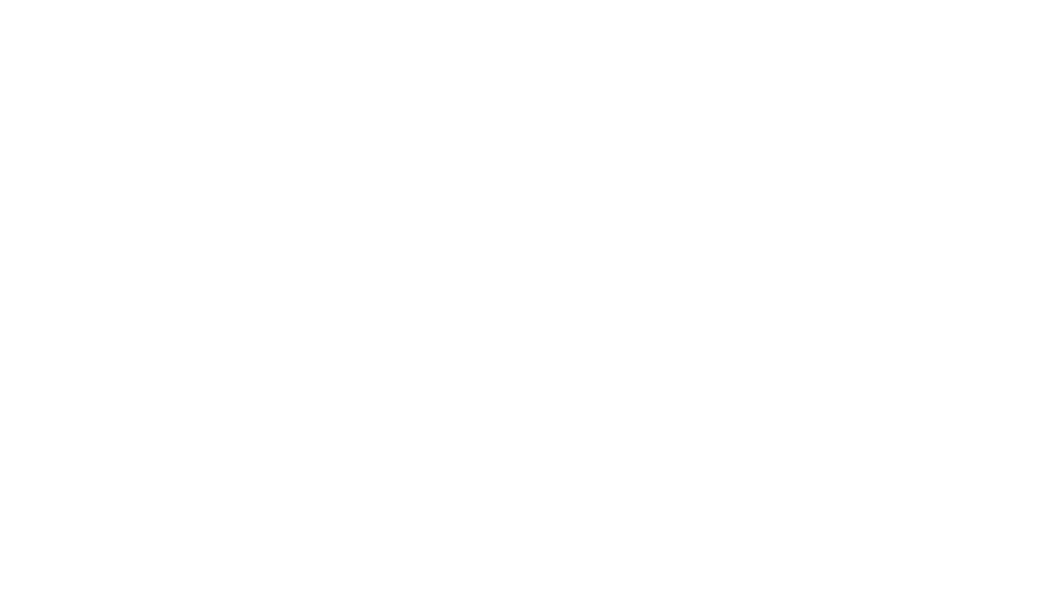

<IPython.core.display.Javascript object>


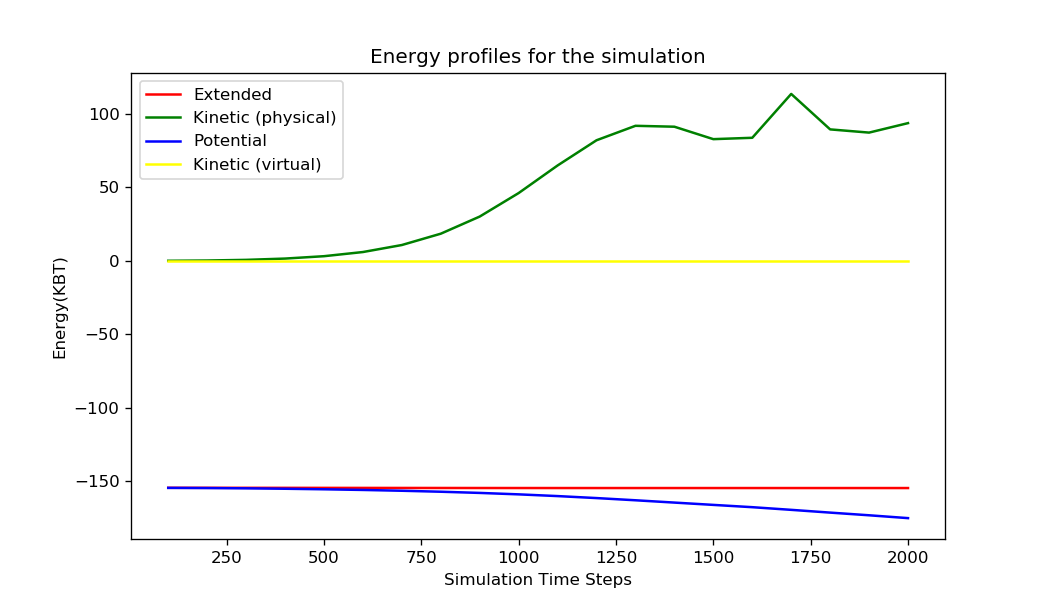

<IPython.core.display.Javascript object>


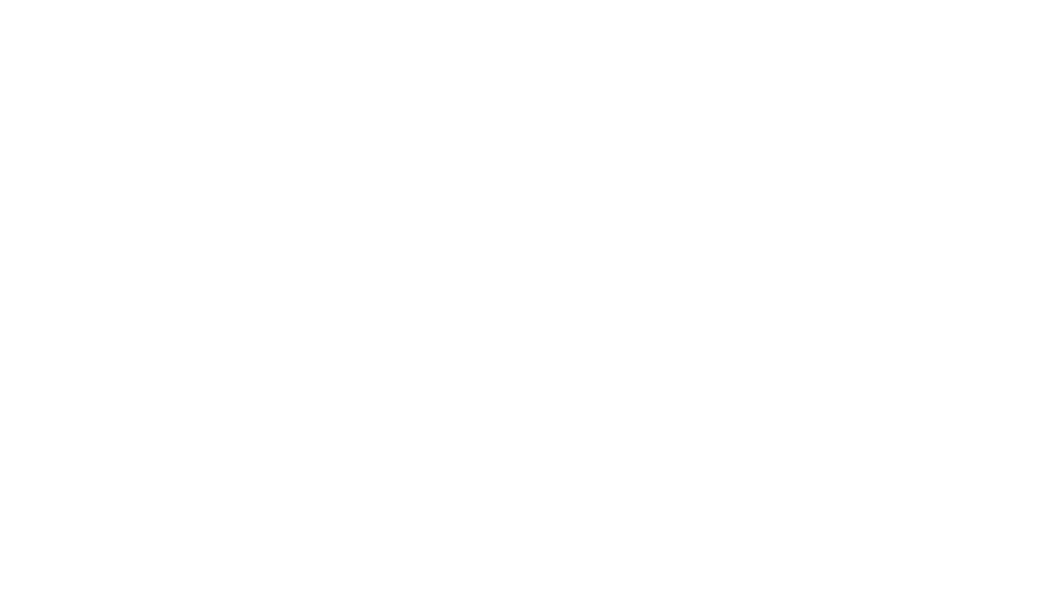

In [21]:
tab_layout=Layout(
    width='100%',
    height='100%'
)

# we want the plot to go here, so create an empty one initially
#create tabs
figsize_tup=(8.75, 5.05)
figure_density = plt.figure(num='Distribution of positive ions', figsize=figsize_tup)
out_desnity = Output(layout=tab_layout)

figure_energy = plt.figure(num='Energy Conservation of the Ionic System', figsize=figsize_tup)
out_energy = Output(layout=tab_layout)

figure_ions = plt.figure(num='Ion Positions', figsize=figsize_tup)
out_ion = Output(layout=tab_layout)


In [22]:
#tab_contents = ['Density Profile', 'Energy Conservation', 'Ion Distribution']
tab_contents = ['Density Profile', 'Energy Conservation']
#children = [out_desnity, out_energy, out_ion]
children = [out_desnity, out_energy]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, str(tab_contents[i]))
tab.selected_index = 1


form_about = [
    Box([tab], layout=form_item_layout)
]

tab = Box(form_about, layout=box_layout_tabs)

In [23]:
def showPlotUI():
    with out_desnity:
        display(figure_density, layout=tab_layout)
    with out_energy:
        display(figure_energy, layout=tab_layout)
    with out_ion:
        display(figure_ions, layout=tab_layout)

In [24]:
#Submit(start_func=callExe, done_func=plot_data, cachename='SubmitTest1')
submit_btn=Submit(start_func=callExe, done_func=plot_data, outcb=stdoutput_handler)

In [25]:
progressBar=widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Progress:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal',
    layout={'width': '100%'},
)

form_items_progress = [
    Box([progressBar], layout=form_item_layout)
]

progressBar_Ele = Box(form_items_progress, layout=box_layout_computing)

In [26]:
form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    padding='5px'
)

box_layout_column_left=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=left_column,
)
box_layout_column_right=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=right_column,
)

box_layout=Layout(
    display='flex',
    flex_flow='row',
    #border='solid 2px',
    align_items='stretch',
    width=app_width,
    #padding='5px',
    height='850px'
)

box_layout_rows=Layout(
    display='flex',
    flex_flow='column',
    #border='solid 2px',
    align_items='stretch',
    width=app_width,
    #padding='5px',
    height='1350px',
    #overflow_x='scroll',
    #overflow_y='scroll'
)


gui_left = [
    Box([mainImage], layout=form_item_layout),
    Box([physical_para], layout=form_item_layout),
    Box([computing_para], layout=form_item_layout),
    Box([progressBar_Ele], layout=form_item_layout)
]

gui_right = [
    Box([about_text], layout=form_item_layout),
    Box([tab], layout=form_item_layout)
]

form_left = Box(gui_left, layout=box_layout_column_left)
form_right = Box(gui_right, layout=box_layout_column_right)

gui_upper = [
    Box([form_left], layout=box_layout_column_left),
    Box([form_right], layout=box_layout_column_right)
]

form = Box(gui_upper, layout=box_layout)

gui = widgets.VBox([form,submit_btn.w],layout=box_layout_rows)


In [27]:
gui

VBox(children=(Box(children=(Box(children=(Box(children=(Box(children=(Box(children=(Box(children=(Image(value=b'\xff\xd8\xff\xe1.\xe3Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x0c\x01\x00\x00\x03\x00\x00\x00\x01\t$\x00\x00\x01\x01\x00\x03\x00\x00\x00\x01\x07\xb4\x00\x00\x01\x02\x00\x03\x00\x00\x00\x03\x00\x00\x00\x9e\x01\x06\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x01\x15\x00\x03\x00\x00\x00\x01\x00\x03\x00\x00\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00\xa4\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00\xac\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x011\x00\x02\x00\x00\x00\x1d\x00\x00\x00\xb4\x012\x00\x02\x00\x00\x00\x14\x00\x00\x00\xd1\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\xe8\x00\x00\x01 \x00\x08\x00\x08\x00\x08\x00-\xc6\xc0\x00\x00\'\x10\x00-\xc6\xc0\x00\x00\'\x10Adobe Photoshop CC (Windows)\x002018:05:10 22:54:58\x00\x00\x00\x00\x00\x04\x90\x00\x00\x07\x00\x00\x00\x040221\xa0\x01\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\xa0\x02\x00\x04\x00\x00\x00\x01\x00\x00\x03\xe8\xa0\x03\x00\x04\x00\x00\x00\x01\x00\x00\x03\xa0\x00\x00\x00\x00\x00\x00\x00\x06\x01\x03\x00\x03\x00\x00\x00\x01\x00\x06\x00\x00\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x01n\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x01v\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x02\x01\x00\x04\x00\x00\x00\x01\x00\x00\x01~\x02\x02\x00\x04\x00\x00\x00\x01\x00\x00-]\x00\x00\x00\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x01\xff\xd8\xff\xed\x00\x0cAdobe_CM\x00\x01\xff\xee\x00\x0eAdobe\x00d\x80\x00\x00\x00\x01\xff\xdb\x00\x84\x00\x0c\x08\x08\x08\t\x08\x0c\t\t\x0c\x11\x0b\n\x0b\x11\x15\x0f\x0c\x0c\x0f\x15\x18\x13\x13\x15\x13\x13\x18\x11\x0c\x0c\x0c\x0c\x0c\x0c\x11\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x01\r\x0b\x0b\r\x0e\r\x10\x0e\x0e\x10\x14\x0e\x0e\x0e\x14\x14\x0e\x0e\x0e\x0e\x14\x11\x0c\x0c\x0c\x0c\x0c\x11\x11\x0c\x0c\x0c\x0c\x0c\x0c\x11\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\xff\xc0\x00\x11\x08\x00\x94\x00\x9f\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xdd\x00\x04\x00\n\xff\xc4\x01?\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x03\x00\x01\x02\x04\x05\x06\x07\x08\t\n\x0b\x01\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x10\x00\x01\x04\x01\x03\x02\x04\x02\x05\x07\x06\x08\x05\x03\x0c3\x01\x00\x02\x11\x03\x04!\x121\x05AQa\x13"q\x812\x06\x14\x91\xa1\xb1B#$\x15R\xc1b34r\x82\xd1C\x07%\x92S\xf0\xe1\xf1cs5\x16\xa2\xb2\x83&D\x93TdE\xc2\xa3t6\x17\xd2U\xe2e\xf2\xb3\x84\xc3\xd3u\xe3\xf3F\'\x94\xa4\x85\xb4\x95\xc4\xd4\xe4\xf4\xa5\xb5\xc5\xd5\xe5\xf5Vfv\x86\x96\xa6\xb6\xc6\xd6\xe6\xf67GWgw\x87\x97\xa7\xb7\xc7\xd7\xe7\xf7\x11\x00\x02\x02\x01\x02\x04\x04\x03\x04\x05\x06\x07\x07\x06\x055\x01\x00\x02\x11\x03!1\x12\x04AQaq"\x13\x052\x81\x91\x14\xa1\xb1B#\xc1R\xd1\xf03$b\xe1r\x82\x92CS\x15cs4\xf1%\x06\x16\xa2\xb2\x83\x07&5\xc2\xd2D\x93T\xa3\x17dEU6te\xe2\xf2\xb3\x84\xc3\xd3u\xe3\xf3F\x94\xa4\x85\xb4\x95\xc4\xd4\xe4\xf4\xa5\xb5\xc5\xd5\xe5\xf5Vfv\x86\x96\xa6\xb6\xc6\xd6\xe6\xf6\'7GWgw\x87\x97\xa7\xb7\xc7\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03\x11\x00?\x00\xf5T\x92I%)$\x07\xe6c3\x9b\x03\x8f\x83}\xc7\xfc\xd6nAwP?\xe0\xea?\x17\x90\xdf\xc1\xbe\xa3\x90\xb0\x13E\xba\x99\xcekAs\x88\x00rN\x81f\xbb\')\xfc\xd9\xb0xV\x00\xff\x00\xa4\xff\x00QR\xb7&\xb2\xec\x9a\xe9a\xcb\xcd\xc4\xa8Zq\xdcHs\xb7\x87:\x863"\xf0\xea\xbfK\xe9\xfeg\xd0C\x8a\xf6\x16\x9e\x17]\xd9\xf8\xc3\xe88\xda\x7f\xe0\xc6\xe1\xfe\x7f\xf3\x7f\xf4\xd0OT!\xeeo\xa0`A\xfaM\x9dG\x87\xd1\xff\x00\xa6\xb2Y\xd5,\xc98\x9fc\xc7\xb0\x8c\xa6\x8b]fC\x1f[\x19S]\xe9\xe40\xbc\x07~\xb9\xff\x00q\xea\x7f\xe8\xae\xfd\xf4\x86-\xb5g\xb5\xac\xccx\xad\xef\xb2\xcb1\xee"\xc7Xl\x1b\xda\xcamym\x94\xd1\x87\xf9\x94\xd7\xbfei\xa6f\xac/\x18\xe8\xd4\xb4\xdf\x7f\x07\\uJ\xfb\xd5g\xcba\xff\x00\xd1\x8aC\xa9\xe3\x9e[c\x7f\xb3?\xf5\x1b\x96\x1fL\xcf=D>\xc6V\xda\xebi\x0ck\x0b\xc1\xbcX\xd2\xfa\xf2i\xca\

../python/train.py:142: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  traing_data_raw=rawdata.drop(['R','R_v','FD','output','Time'], axis=1).as_matrix().astype('float64')
../python/train.py:143: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  output_raw = rawdata['output'].copy().as_matrix().astype('int')
